# Prepare dataset for modeling

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
import pandas as pd
import seaborn as sns
from collections import Counter

import xarray as xr
import glob
import rioxarray

from scipy import ndimage
from scipy.ndimage import label, binary_fill_holes, binary_erosion, generate_binary_structure
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1. Parameters

In [2]:
# Directory containing .zarr files
DATA_DIR = "/home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target"

# Bands to use for analytics
BANDS = ["b02", "b03", "b04", "b8a", "b11", "b12", 'amei', 'ndwi']  # Blue, Green, Red, NIR, NIR narrow, SWIR1, SWIR2

# zarr files
zarr_files = glob.glob(os.path.join(DATA_DIR, "*.zarr"))

# Select month
june_files = [
    f for f in zarr_files
    if os.path.basename(f).split("_")[2][:8][4:6] == "06"
]

random.seed(2)

# 2. Helper functions

In [3]:
def resample_to_10m(ds, band, ref, folder):
    """
    Resample band to match the resolution & grid of reference band.
    ds: opened .zarr datatree
    band: name of band to resample (string)
    ref: name of reference band (string)
    """
    crs_code = "EPSG:32632"

    # Define reference band
    ref_band = ds[f"measurements/reflectance/r10m/{ref}"]  # reference (10m red)
    ref_band = ref_band.rio.write_crs(crs_code, inplace=True)

    # Band to convert
    if folder == 'measurements':
        band_20m = ds[f"measurements/reflectance/r20m/{band}"]
    else:
        band_20m = ds[f"conditions/mask/l2a_classification/r20m/{band}"] # for classification band
    band_10m = band_20m.rio.write_crs(crs_code, inplace=True)  # ensure CRS

    return band_10m.rio.reproject_match(ref_band)

def compute_amei(ds, eps=1e-6):
    red   = ds["measurements/reflectance/r10m/b04"].values.astype(np.float32) / 10000
    green = ds["measurements/reflectance/r10m/b03"].values.astype(np.float32) / 10000
    nir   = resample_to_10m(ds, 'b8a', 'b04', folder='measurements')
    nir = nir.values.astype(np.float32) / 10000
    swir  = resample_to_10m(ds, 'b11', 'b04', folder='measurements')
    swir = swir.values.astype(np.float32) / 10000  # "B11" or "B12"

    # AMEI = (2*red + nir - 2*swir) / (green + 0.25*swir)
    denom = green + 0.25 * swir
    amei  = (2*red + nir - 2*swir) / (denom + eps)  # eps avoids divide-by-zero

    return amei

def compute_ndwi(ds, eps=1e-6):
    green = ds["measurements/reflectance/r10m/b03"].values.astype(np.float32) / 10000
    nir   = resample_to_10m(ds, 'b8a', 'b04', folder='measurements')
    nir = nir.values.astype(np.float32) / 10000

    # NDWI = (green - nir) / (green + nir)
    ndwi  = (green - nir) / (green + nir + eps)  # eps avoids divide-by-zero

    return ndwi


def build_stack_10m(ds, bands):
    """
    Create (H, W, C) stack from selected bands/indices.
    """
    stack = []
    ref_10m = ds["measurements/reflectance/r10m/b04"]  # reference (10m red)
    
    for b in bands:
        if b in ds['measurements/reflectance/r10m']:   # reflectance at 10m
            arr = ds['measurements/reflectance/r10m'][b].values.astype(np.float32) / 10000
        elif b in ds['measurements/reflectance/r20m']: # reflectance at 20m
            arr = resample_to_10m(ds, b, 'b04', folder='measurements')
            arr = arr.values.astype(np.float32) / 10000
        elif b == "amei":
            arr = compute_amei(ds)
        elif b == "ndwi":
            arr = compute_ndwi(ds)
        else:
            raise ValueError(f"Band {b} not found or not supported.")
        
        stack.append(arr)
    stack = np.stack(stack, axis=-1)  # (H, W, C)
    return stack

# 3. Patchify

## Prepare 256x256xbands patches from each image. Patches are created all over the image (1764 patches for each image)

In [5]:
def extract_patches_3d(array, patch_size=256, stride=256):
    """
    Extract patches from (H, W, C) array.
    Returns a list of patches with shape (patch_size, patch_size, C).
    """
    H, W, C = array.shape
    patches = []

    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            patch = array[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)
    return patches


def process_folder(zarr_files, bands, patch_size=256, stride=256):
    """
    Loop through all zarr files in a folder and extract patches.
    """
    all_patches = []

    for zf in zarr_files:
        print(f"Processing {zf} ...")
        ds = xr.open_datatree(zf, engine="zarr", mask_and_scale=False)

        stack = build_stack_10m(ds, bands)
        patches = extract_patches_3d(stack, patch_size, stride)
        
        all_patches.extend(patches)
    
    return all_patches

In [4]:
patches = process_folder(zarr_files[:2], BANDS)

print(f"Total patches: {len(patches)}")
print(f"Patch shape: {patches[0].shape}")

Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2B_MSIL2A_20240728T095549_N0511_R122_T32TQQ_20240728T114034.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2A_MSIL2A_20240723T100031_N0511_R122_T32TQR_20240723T155949.zarr ...
Total patches: 3528
Patch shape: (256, 256, 8)


## Strategic patchify. Generate patches along the water border.

In [4]:
def clean_water_mask(water_mask):
    """
    Fix water mask by:
    1. Keeping only the sea (remove lakes/rivers).
    2. Filling cloud holes in the sea.
    """
    H, W = water_mask.shape
    
    # Keep only the largest connected component that touches border (most prob the sea)
    st = generate_binary_structure(2, 2)   # 8-connectivity
    lab, nlab = label(water_mask, structure=st) # different label for each connected water body
    
    if nlab == 0:
        return np.zeros_like(water_mask, dtype=bool)

    # Find component sizes
    sizes = np.bincount(lab.ravel())
    sizes[0] = 0  # background, we don't consider it

    # Keep the largest component
    largest_label = sizes.argmax()
    sea_only = (lab == largest_label)

    # Fill holes inside sea (caused by clouds)
    sea_filled = binary_fill_holes(sea_only)

    return sea_filled.astype(bool)

def sample_patch_centers(water_mask, n_patches, patch_size=256, border_weight=0.7):
    """
    Randomly sample patch centers with more focus on water-land borders.
    """
    H, W = water_mask.shape
    
    # Create a mask from the shoreline (water/land border) expanding seawards
    border_mask = water_mask & ~binary_erosion(water_mask, iterations=300) # choose pixels number
    
    # Probability map
    probs = np.zeros_like(water_mask, dtype=np.float32)
    probs[border_mask] = border_weight   # 70% on border
    probs[water_mask]  = 1.0 - border_weight  # 30% on water
    
    probs = probs / probs.sum()  # normalize to 1
    
    # Flatten and sample indices
    flat_idx = np.random.choice(H*W, size=n_patches, replace=False, p=probs.ravel()) # randomly picks pixel indices based on the prob map (p)
    centers = np.column_stack(np.unravel_index(flat_idx, (H, W))) # convert indices back into (row, col) coordinates in the 2D image
    
    # Convert to (row, col) top-left corners
    half = patch_size // 2 # centering
    corners = [(max(0, r-half), max(0, c-half)) for r, c in centers]
    del probs
    
    return corners


def extract_patches_focus(stack, water_mask, n_patches=100, patch_size=256):
    """
    Extract (256,256,C) patches with sampling biased toward border regions.
    """
    H, W, C = stack.shape
    corners = sample_patch_centers(water_mask, n_patches, patch_size)
    
    patches = []
    for i, j in corners:
        if i+patch_size <= H and j+patch_size <= W:
            patches.append(stack[i:i+patch_size, j:j+patch_size, :])
    del corners

    return patches


def process_folder_opt(zarr_files, bands, water_mask):
    """
    Loop through all zarr files in a folder and extract patches.
    """
    all_patches = []

    for zf in zarr_files:
        print(f"Processing {zf} ...")
        ds = xr.open_datatree(zf, engine="zarr", mask_and_scale=False)

        stack = build_stack_10m(ds, bands)
        stack = stack.astype(np.float16)
        patches = extract_patches_focus(stack, water_mask)
        
        all_patches.extend(patches)
        del ds, stack, patches # to avoid RAM overload
    
    return all_patches


def plot_patch_grid(patches, n=10, rgb_idx=(2,1,0)):
    """
    Show n x n grid of RGB patches.
    - patches: list of (256,256,C) arrays
    - n: grid size
    - rgb_idx: indices of stack channels to use as RGB (default assumes [b2,b3,b4,...])
    """
    fig, axes = plt.subplots(n, n, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # pick random patches
    chosen = random.sample(patches, n*n) if len(patches) > n*n else patches[:n*n]

    for ax, patch in zip(axes.flat, chosen):
        # select RGB channels
        rgb = patch[..., list(rgb_idx)]
        rgb = rgb.astype(np.float32)

        # simple normalization (per patch)
        p2, p98 = np.nanpercentile(rgb, (2, 98))
        rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)

        ax.imshow(rgb)
        ax.axis("off")

    plt.show()
    plt.close("all")

In [5]:
# Generate water mask
# NOTE: here the water mask is generated from the first file and kept for all the others

dt = xr.open_datatree(june_files[2], engine="zarr", mask_and_scale=False) # better to take the water mask from a cloud free day (clouds are considered as nonwater)
scl = resample_to_10m(dt, 'scl', 'b04', folder='conditions') # 10m resolution
scl = scl.squeeze().values
raw_water_mask = (scl == 6)
water_mask = clean_water_mask(raw_water_mask) # remove inland lakes and fill clouds over sea

patches = process_folder_opt(june_files, BANDS, water_mask)

Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2A_MSIL2A_20240606T100601_N0510_R022_T32TQQ_20240606T175100.zarr ...


/tmp/ipykernel_490854/2434118914.py:43: RuntimeWarning: divide by zero encountered in divide
  ndwi  = (green - nir) / (green + nir + eps)  # eps avoids divide-by-zero
/tmp/ipykernel_490854/728562677.py:84: RuntimeWarning: overflow encountered in cast
  stack = stack.astype(np.float16)


Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2B_MSIL2A_20240618T095549_N0510_R122_T32TQQ_20240618T124428.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2A_MSIL2A_20240616T100601_N0510_R022_T32TQQ_20240616T160951.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2B_MSIL2A_20240628T095549_N0510_R122_T32TQQ_20240628T124047.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2B_MSIL2A_20240601T100559_N0510_R022_T32TQQ_20240601T125555.zarr ...


/tmp/ipykernel_490854/2434118914.py:33: RuntimeWarning: divide by zero encountered in divide
  amei  = (2*red + nir - 2*swir) / (denom + eps)  # eps avoids divide-by-zero
/tmp/ipykernel_490854/2434118914.py:43: RuntimeWarning: divide by zero encountered in divide
  ndwi  = (green - nir) / (green + nir + eps)  # eps avoids divide-by-zero
/tmp/ipykernel_490854/728562677.py:84: RuntimeWarning: overflow encountered in cast
  stack = stack.astype(np.float16)


### Visualize border mask

In [48]:
dt = xr.open_datatree(june_files[2], engine="zarr", mask_and_scale=False)
scl = resample_to_10m(dt, 'scl', 'b04', folder='conditions') # 10m resolution
scl = scl.squeeze().values
raw_water_mask = (scl == 6)
water_mask = clean_water_mask(raw_water_mask)
border_mask = water_mask & ~binary_erosion(water_mask, iterations=300)

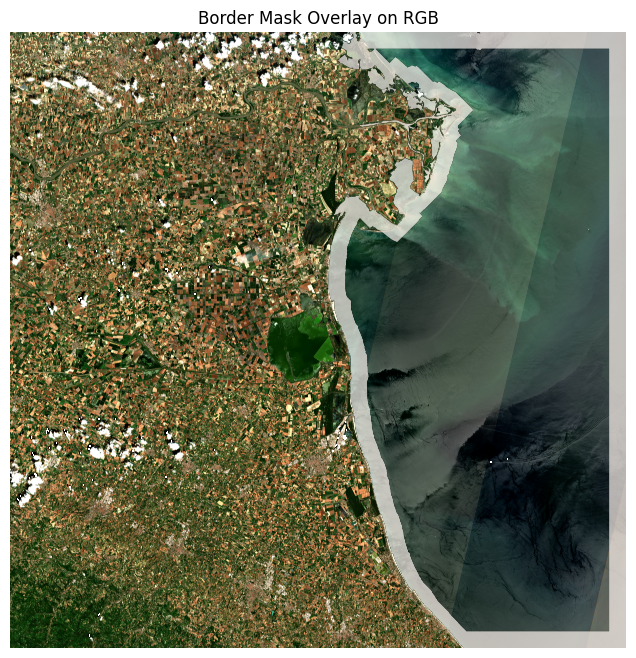

In [49]:
# Plot border mask

rgb = np.dstack([
    dt['measurements/reflectance/r10m/b04'].values.astype(np.float32) / 10000.0,
    dt['measurements/reflectance/r10m/b03'].values.astype(np.float32) / 10000.0,
    dt['measurements/reflectance/r10m/b02'].values.astype(np.float32) / 10000.0
])
p2, p98 = np.nanpercentile(rgb, (2, 98))
rgb = np.clip((rgb - p2) / (p98 - p2), 0, 1)

# Plot RGB
plt.figure(figsize=(10, 8))
plt.imshow(rgb)

# Overlay border mask in red (alpha controls transparency)
plt.imshow(np.where(border_mask, 1, np.nan), cmap="Reds", alpha=0.7)

plt.title("Border Mask Overlay on RGB")
plt.axis("off")
plt.show()

plt.close("all")
del rgb

### Visulaize patches

/home/ubuntu/.conda/envs/eopf/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


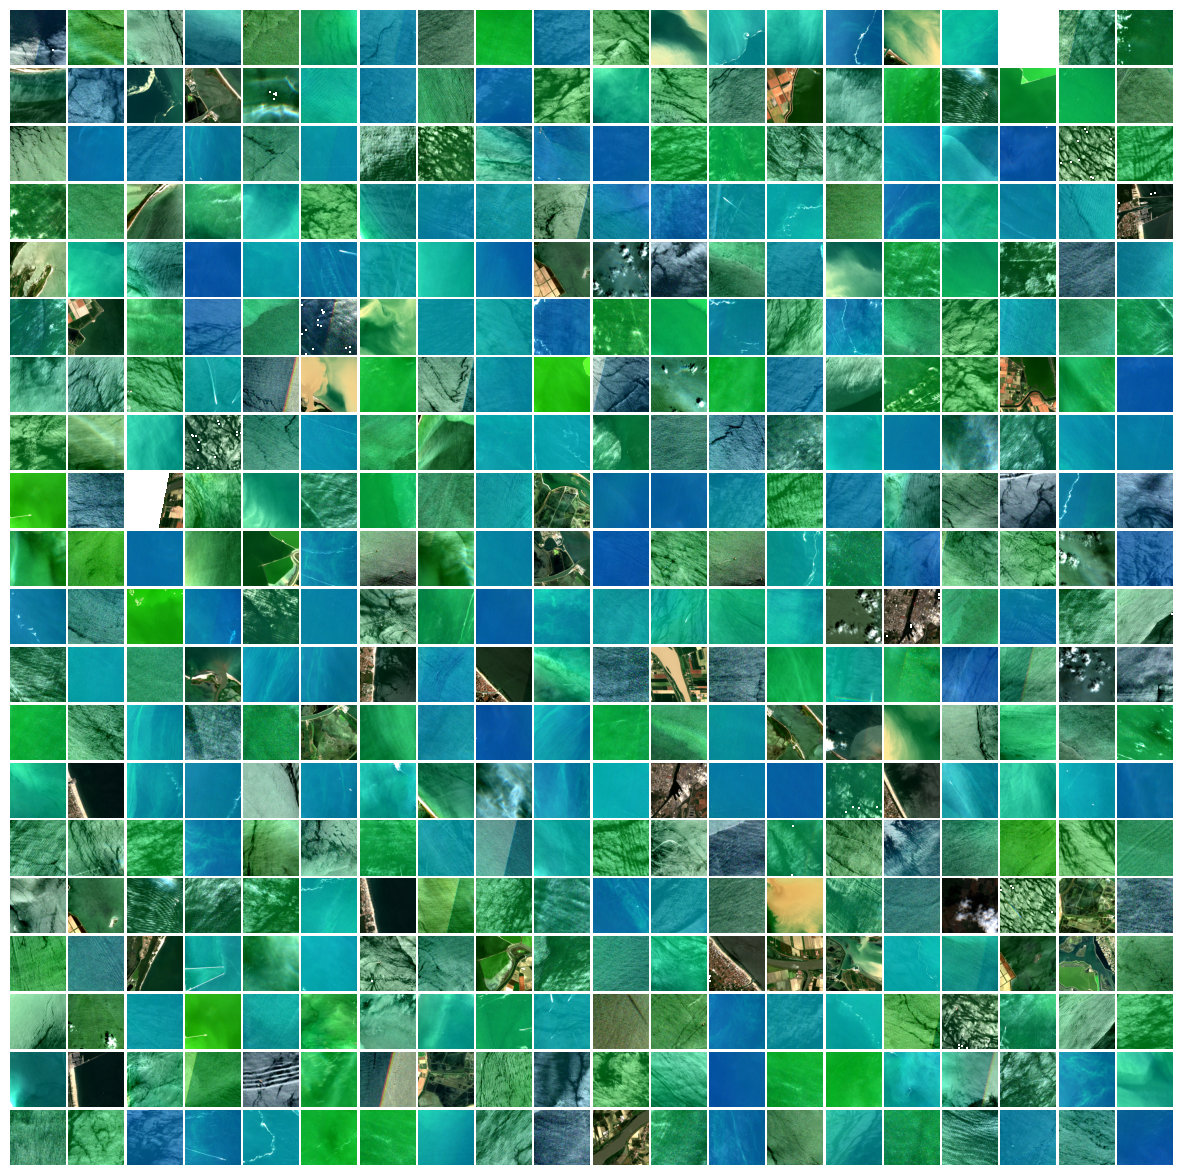

In [15]:
plot_patch_grid(patches, n=20, rgb_idx=(2,1,0))

### Analyses on patches

In [6]:
# Faulty patches (contain infite values)
patches_array = np.array(patches)  # shape (n, 256, 256, 8)

# Check each patch
bad_patches = []
for i, p in enumerate(patches_array):
    if np.isnan(p).any() or np.isinf(p).any():
        bad_patches.append(i)

print(f"Number of bad patches: {len(bad_patches)}")
print("Indices of bad patches:", bad_patches)

patches = np.delete(patches_array, bad_patches, axis=0)

Number of bad patches: 14
Indices of bad patches: [9, 11, 19, 35, 62, 65, 70, 80, 227, 395, 417, 424, 428, 470]


In [7]:
def patch_features(patch):
    # patch: (256, 256, 8) with bands [B2, B3, B4, B8, B11, B12, AMEI, NDWI]

    # Exclude redundant patches (from correlation matrix, B3 and B11)
    keep_idx = [0, 2, 3, 5, 6, 7]
    patch_sel = patch[:, :, keep_idx]

    feats = []
    
    # per-channel mean and std
    feats.extend(patch.mean(axis=(0,1)))  # 8 features
    feats.extend(patch.std(axis=(0,1)))   # 8 features
    
    return np.array(feats)

# Build feature matrix
X = np.array([patch_features(p) for p in patches])  # shape: (N_patches, 16)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Kmeans
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)

In [23]:
print(X[0])

[ 2.205e-06  4.172e-06  1.490e-06 -8.941e-07  2.980e-07  4.768e-07
  2.815e-01  1.214e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  9.827e-02  3.933e-01]


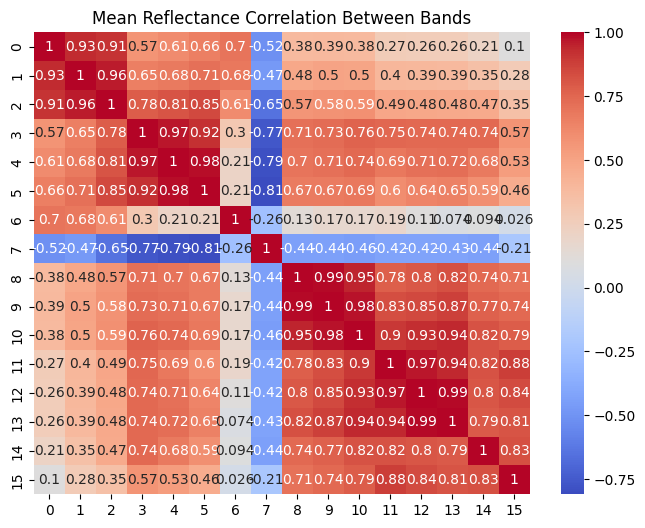

In [36]:
corr =  pd.DataFrame(X).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Mean Reflectance Correlation Between Bands")
plt.show()

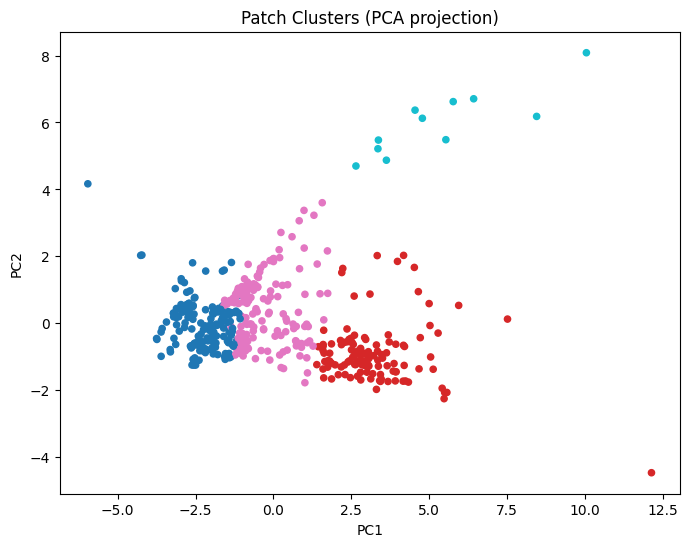

In [8]:
X_pca = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="tab10", s=20)
plt.title("Patch Clusters (PCA projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In [9]:
# Remove the outlie in the plot

outlier_idx = np.where(X_pca[:, 0] > 10)[0]  # PC1 is column 0
print("Outlier indices:", outlier_idx)

# Remove them from everything
X_clean = np.delete(X_scaled, outlier_idx, axis=0)
X_pca_clean = np.delete(X_pca, outlier_idx, axis=0)
labels_clean = np.delete(labels, outlier_idx, axis=0)  # if you already clustered
patches_clean = [p for i, p in enumerate(patches) if i not in outlier_idx]

Outlier indices: [131 314]


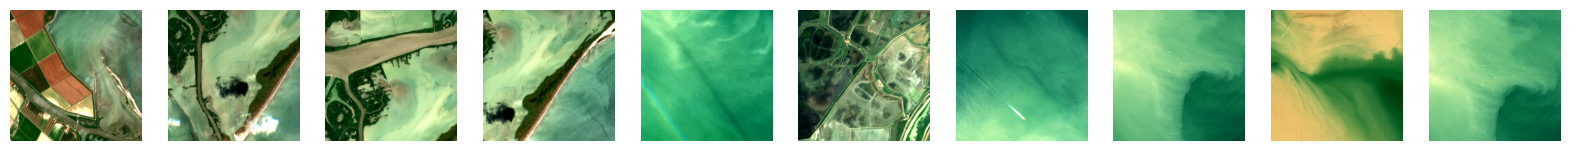

In [ ]:
def show_cluster_examples(patches, labels, cluster_id, n=10):
    idxs = np.where(labels==cluster_id)[0][:n]
    fig, axes = plt.subplots(1,n, figsize=(20,3))
    for ax,i in zip(axes, idxs):
        # show true-color RGB (B4,B3,B2 → indices 2,1,0)
        rgb = patches[i][:,:, [2,1,0]]
        p2, p98 = np.nanpercentile(rgb, (2, 98))
        rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)
        ax.imshow(rgb)
        ax.axis("off")
    plt.show()
    plt.close('all')

show_cluster_examples(patches, labels, cluster_id=1)

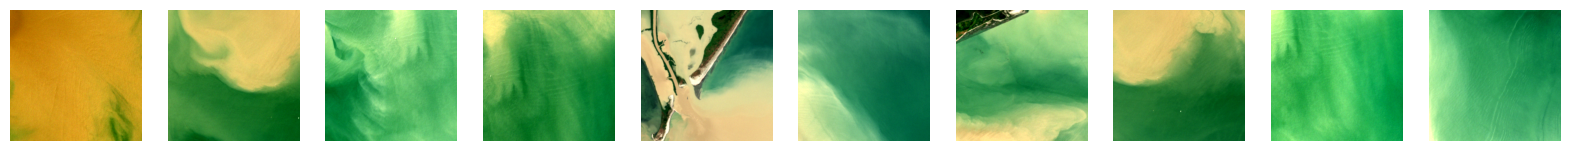

In [14]:
def show_cluster_examples(patches, labels, cluster_id, n=10):
    idxs = np.where(labels==cluster_id)[0][:n]
    fig, axes = plt.subplots(1,n, figsize=(20,3))
    for ax,i in zip(axes, idxs):
        # show true-color RGB (B4,B3,B2 → indices 2,1,0)
        rgb = patches[i][:,:, [2,1,0]]
        p2, p98 = np.nanpercentile(rgb, (2, 98))
        rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)
        ax.imshow(rgb)
        ax.axis("off")
    plt.show()
    plt.close('all')

show_cluster_examples(patches, labels, cluster_id=3)

In [15]:
# Check for balance

counts = Counter(labels)
print(counts)

Counter({np.int32(0): 178, np.int32(2): 156, np.int32(1): 122, np.int32(3): 11})


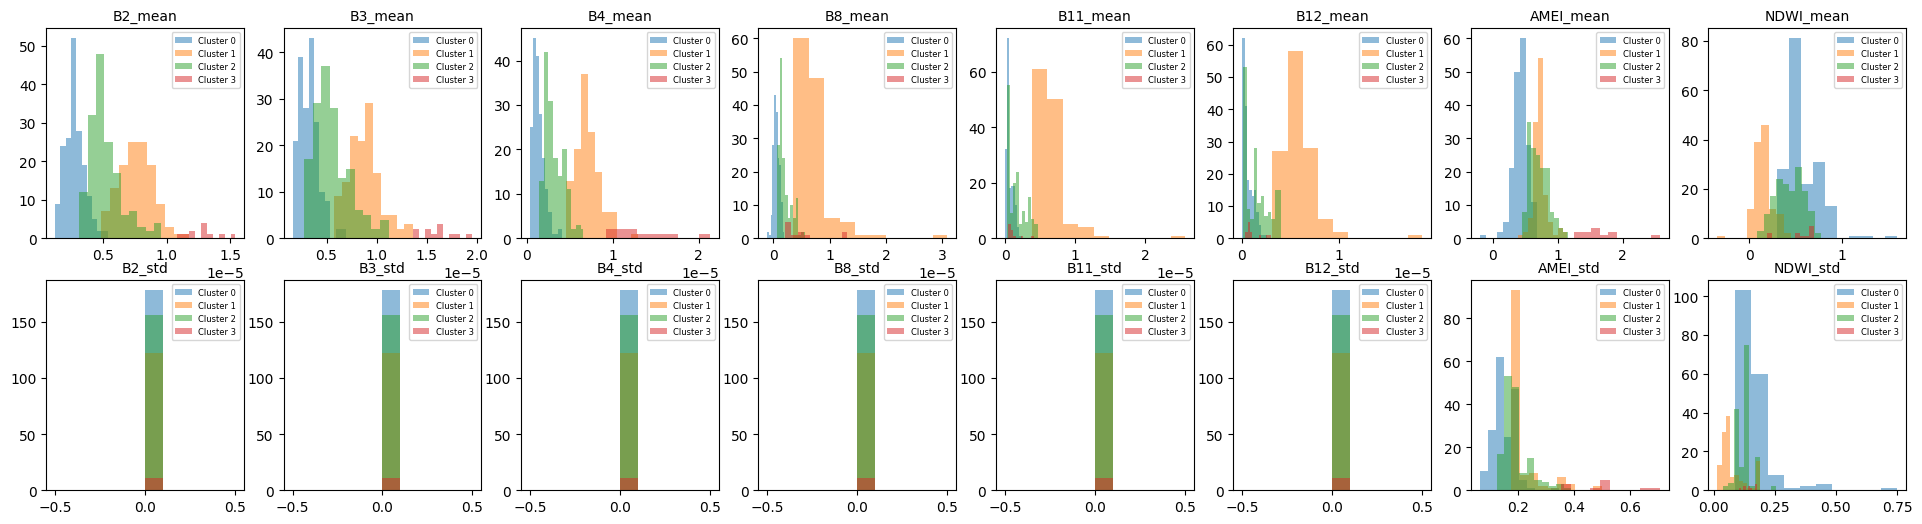

In [18]:
feature_names = ["B2_mean","B3_mean", "B4_mean", "B8_mean","B11_mean", "B12_mean", "AMEI_mean", "NDWI_mean", 
                 "B2_std","B3_std", "B4_std", "B8_std","B11_std", "B12_std", "AMEI_std", "NDWI_std"]

fig, axes = plt.subplots(2, 8, figsize=(24, 6))
axes = axes.ravel()
for i, fname in enumerate(feature_names):
    ax = axes[i]
    for cluster_id in np.unique(labels):
        ax.hist(X[labels == cluster_id, i], bins=10, alpha=0.5, label=f'Cluster {cluster_id}')
    ax.set_title(fname, fontsize=10)
    ax.legend(fontsize=6)
plt.show()

# 4. Prepare dataset

Split into train/test/validation

In [ ]:
# Create (N, 256, 256, 8) array
patches = np.array(patches, dtype=np.float32)

np.random.seed(42)  # reproducibility
np.random.shuffle(patches)

n_total = len(patches)
train_end = int(0.7 * n_total)
val_end   = int(0.85 * n_total)

train_set = patches[:train_end]
val_set   = patches[train_end:val_end]
test_set  = patches[val_end:]

In [12]:
print(train_set.shape)

(2469, 256, 256, 8)
